# 0 - IMPORTS AND CONSTANTS

All modules, imports, libraries and constant used in this file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np


# All the validation metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# imports of class created by me
from ForestaRandomica import ForestaRandomica


INPUT_FILE_PATH = 'mnist_784.csv'
METRICS_PARAMETER={accuracy_score:None, recall_score:{'average':None}, precision_score:{'average':None}, f1_score:{'average':None}}


# 1 - DATA READING AND PARTITIONING

Load the MNIST dataset into memory. <br>
Divide the 70,000 digits you have into:
- training set (60,000 digits) 
- test set (10,000 digits).

In [2]:
def readMnistDataset(file:str)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=file, header=0).rename(columns={'class':'label'})

# 2 - SINGLE RANDOM TREE

Train a single decision tree (with the default parameters) on the training set, then compute its
accuracy on the test set.

In [3]:
def computeMetrics(yTrue:pd.DataFrame, yPred:pd.DataFrame, metrics:list=METRICS_PARAMETER,
                    printMap: bool=False)->dict[str:float]:
    if printMap:
        fig, ax = plt.subplots(1,1,figsize=(12,12))
        sns.heatmap(confusion_matrix(yTrue, yPred), annot=True, ax=ax)
        plt.show()
    
    val = pd.DataFrame({str(metric).split()[1]:(metric(yTrue, yPred, **metrics[metric])if metrics[metric] else metric(yTrue, yPred))*100
            for metric in metrics})
    
    return (pd.concat([val, val.agg(func=['mean', 'min', 'max', 'std'], axis=0)], axis=0)
            .map(lambda x: x if not isinstance(x, float) else (round(x, 3) if x > 1e-6 else 0)))

def createAndTestSingleRandomTree(xTrain:pd.DataFrame, xTest:pd.DataFrame, yTrain:pd.DataFrame, yTest:pd.DataFrame, 
                                metrics:list=METRICS_PARAMETER, printMap: bool=False)->dict[str:float]:
    
    print("FINAL RESULTS OF A SINGLE DECISION TREE :") 
    
    return computeMetrics(yTest, DecisionTreeClassifier().fit(xTrain, yTrain).predict(xTest),
                            metrics=metrics, printMap=printMap)
    

# 3 - MY OWN RANDOM FOREST

Was implemented in the class ForestaRandomica.<br>
This function just tests it

# 4 - TEST MY RANDOM FOREST

Now train your random forest with the 60,000 points of the training set and compute its accuracy
against the test set. How does the random forest behave? How does it compare to a decision tree? <br>
How does this performance vary as the number of estimators grow? Try values from 10 to 100 (with
steps of 10) for n_estimators.

In [4]:
def testMyOwnRandomForest(xTrain:pd.DataFrame, xTest:pd.DataFrame, yTrain:pd.DataFrame, yTest:pd.DataFrame, 
                        estimators:int=10)->pd.DataFrame:
    print(f"FINAL RESULTS OF MY RANDOM FOREST OF {estimators} TREES")
    return computeMetrics(yTest, ForestaRandomica(nEstimators=estimators).fit(xTrain, yTrain).predict(xTest), printMap=True)
    

# 5 - SKLEARN RANDOM FOREST

Scikit-learn implements its own version of a random forest classifier, which is unsurprisingly called
RandomForestClassifier (from sklearn.ensemble). Answer the same questions as the previous
exercise. How does your implementation of the random forest compare to sklearn’s?


In [5]:
def testSKlearnRandomForest(xTrain:pd.DataFrame, xTest:pd.DataFrame, yTrain:pd.DataFrame, yTest:pd.DataFrame, 
                        estimators:int=10)->pd.DataFrame:
    print(f"FINAL RESULTS OF SKLEARN RANDOM FOREST OF {estimators} TREES")
    return computeMetrics(yTest, RandomForestClassifier(n_estimators=estimators).fit(xTrain, yTrain).predict(xTest), printMap=True)
    

# 6 - FEATURE IMPORTANCE 

Much like for decision trees, sklearn’s random forests can compute the importance of the features
used. It does this by aggregating the feature importance of the trees into a single value. If $I_{ab}$ is
the feature importance of the $a^{th}$ feature according to the $b^{th}$ tree, the feature importance for a
according to the random forest can be computed as follows:<br>
$Ia = \frac{\sum_j I_{aj}}{\sum_i\sum_j I_{ij}}$

That is, the overall feature importance for any feature is given by the sum of the feature importance
for that feature across all trees, divided by the sum of the feature importances across all trees.
This makes it so that $\sum_i I_i = 1$. <br>
Compute the feature importance for the 784 features of MNIST
according to your random forest (to compute the feature importance of each tree, you can either use
sklearn’s precomputed feature importance, tree.feature_importances_, or you can use your own
implementation from Exercise 1).


In [6]:
def computeFeatureImportance(forest:ForestaRandomica, sort:bool=False)->pd.DataFrame:
    return forest.getFeatureImportance(sort=sort)

# 7 - FEATURE IMPORTANCE VISUALIZATION

From the previous exercise, you should now have an array with 784 feature importances, one for
each of the features in MNIST. You can reshape this array to a 28 × 28 matrix of values (remember
that MNIST images are 28×28 black and white images). You can use the seaborn library to visualize
a heatmap of this matrix (i.e. a 2D grid where elements have different colors based on their value).<br>
Now train a random forest from sklearn, extract its feature importance (rf.feature_importances_)
and visualize it. 
- Does it resemble your results? 
- What are the most important features? 
<br>From Lab 1, you should have some idea as to which features are most relevant to distinguish 0’s from 1’s. 
- Are those pixels also relevant for the 10 classes problem?

In [7]:
def visualizeFeatureImportance(df:pd.DataFrame, ax:str=None)->None:
    sns.heatmap(np.reshape(df, (28,28)), cmap='binary', ax=ax)

# MAIN FUNCTION

This is the main function of the program, it does the following things:
<ol>
<li>Reads the mnist dataset and partitions it</li>
<li>Trains a single decision tree and test it's accuracy</li>
<li>Try implementing a random forest classifier</li>
<li>Tests the newly implemented random forest</li>
<li>Use sklearn implementation of a random forest</li>
<li>Computes the importance of each feature</li>
<li>Visualization of feature importance</li>
</ol> 

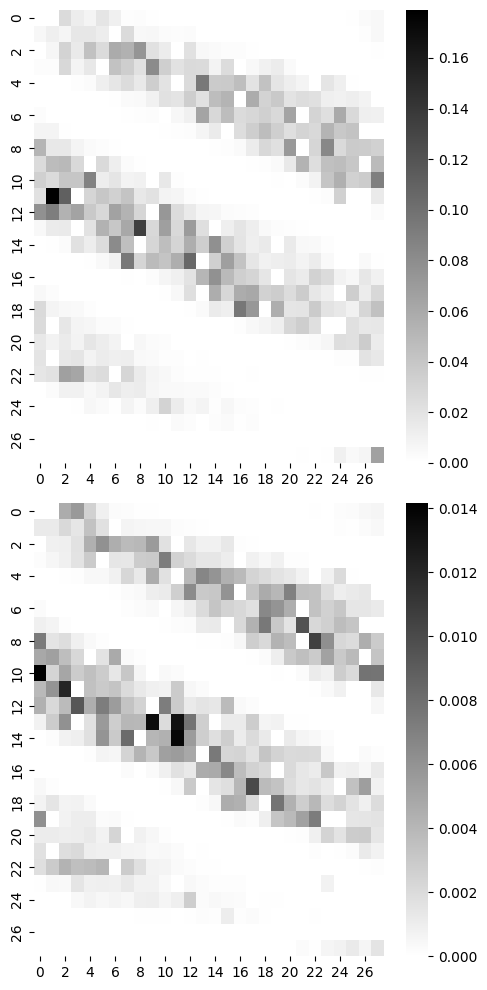

In [8]:
def main()->None:
    df = readMnistDataset(INPUT_FILE_PATH) # 1
    xTrain, xTest, yTrain, yTest = train_test_split(df.loc[:, df.columns.difference({'label'})], 
                                                    df['label'], test_size=1/7, shuffle=True, stratify=df['label']) # 1
    
    # display(createAndTestSingleRandomTree(xTrain, xTest, yTrain, yTest, printMap=True)) # 2
    
    # 3 check class ForestaRandomica
    
    # for estimators in range(10, 100, 10): # 4
        # display(testMyOwnRandomForest(xTrain, xTest, yTrain, yTest, estimators)) # 4
        
    # display(testMyOwnRandomForest(xTrain, xTest, yTrain, yTest, 20)) # 4
    # display(testSKlearnRandomForest(xTrain, xTest, yTrain, yTest, 20))  # 5  
    
    # temp = computeFeatureImportance(ForestaRandomica(nEstimators=10).fit(xTrain, yTrain)) # 6
    #display(temp[temp['importance']>0.05]) # 6
    
    
    fig, ax = plt.subplots(2,1, figsize=(5,10))
    visualizeFeatureImportance(computeFeatureImportance(ForestaRandomica(nEstimators=10).fit(xTrain, yTrain), sort=False), ax=ax[0]) # 7
    visualizeFeatureImportance(RandomForestClassifier(n_estimators=10).fit(xTrain, yTrain).feature_importances_, ax=ax[1]) # 7
    plt.tight_layout()

main()